In [11]:
import os
import zipfile
from pathlib import Path

# Define paths
dataset_folder = Path("./data/leapGestRecog").expanduser()  # Adjust folder name as needed
zip_path = Path("./data/archive.zip").expanduser()

if not dataset_folder.parent.exists():
    print(f"Creating the directory: {dataset_folder.parent}")
    dataset_folder.parent.mkdir(parents=True, exist_ok=True)

# Check if dataset folder exists
if not dataset_folder.exists():
    print("Dataset not found locally. Downloading...")
    
    if not zip_path.exists():
        # Run shell command to download the dataset if it doesn't exist
        !curl -L -o {zip_path} https://www.kaggle.com/api/v1/datasets/download/gti-upm/leapgestrecog
    
    # Unzip the downloaded file
    if zip_path.exists():
        print("Download complete. Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_folder)  # Extracts to the folder above the zip file
        print("Extraction complete.")
    else:
        print("Download failed. Please check your connection or Kaggle API credentials.")
else:
    print("Dataset already exists locally.")


Dataset already exists locally.


In [ ]:
# import cv2
# import numpy as np
# import os

# # Folder containing images
# folder_path = './data/leapGestRecog/leapGestRecog/00/01_palm/'

# # List to store image data and corresponding labels (if available)
# images = []
# labels = []  # Optional if you have labels for supervised learning

# # Iterate over the image files in the folder
# for filename in os.listdir(folder_path):
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         # Read each image in grayscale
#         img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        
#         # Ensure the image is not None
#         if img is not None:
#             # Flatten the 2D image into a 1D array (each pixel is a feature)
#             img_flattened = img.flatten()  # This converts the image to a 1D array
#             images.append(img_flattened)
            
#             # Example: if you have labels for supervised learning, you could store them
#             # labels.append(label)  # e.g., label = 0 or 1 for gesture class

# # Convert images list into a NumPy array (2D array, where each row is an image)
# X = np.array(images)
# # If labels exist, convert them to a NumPy array as well
# # y = np.array(labels)

# print("Shape of image data:", X.shape)


In [23]:
import cv2
import numpy as np
import os



# Resize images to a common size (128x128)
desired_size = (128, 128)


# initialize the list of images and labels
images = []
labels = []

# We only want to work with the first person's data for now (folder '00')
base_folder = './data/leapGestRecog/leapGestRecog/00/'

if os.path.isdir(base_folder):
    # for each gesture folder
    for gesture_folder in os.listdir(base_folder):
        gesture_path = os.path.join(base_folder, gesture_folder)
        
        # Check if it's a directory
        if os.path.isdir(gesture_path):
            
            # Use gesture folder as label
            label = gesture_folder 
            
            # for each image in the gesture folder
            for filename in os.listdir(gesture_path):
                
                # Check if the file is an image
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    
                    # Read the image, convert to grayscale, resize, and normalize
                    img = cv2.imread(os.path.join(gesture_path, filename), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                    
                        img_resized = cv2.resize(img, desired_size)
                        img_normalized = img_resized.astype('float32') / 255.0
                        images.append(img_normalized)
                        labels.append(label)

In [24]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalizes all images
# Augments the images using ImageDataGenerator
# with random rotation, width shift, height shift, zoom, brightness, horizontal flip, and shear
# to create new images for each gesture class
# which imporves the model's ability to generalize to new data
# Saves the augmented images to a new directory


# Resize images to a common size (128x128)
desired_size = (128, 128)

# Initialize the list of images and labels
images = []
labels = []

# We only want to work with the first person's data for now (folder '00')
base_folder = './data/leapGestRecog/leapGestRecog/00/'

if os.path.isdir(base_folder):
    # For each gesture folder
    for gesture_folder in os.listdir(base_folder):
        gesture_path = os.path.join(base_folder, gesture_folder)
        
        # Check if it's a directory
        if os.path.isdir(gesture_path):
            # Use gesture folder as label
            label = gesture_folder 
            
            # For each image in the gesture folder
            for filename in os.listdir(gesture_path):
                # Check if the file is an image
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    # Read the image in grayscale and resize
                    img_path = os.path.join(gesture_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img_resized = cv2.resize(img, desired_size)
                        # Keep the image in uint8 format with pixel values in [0, 255]
                        images.append(img_resized)
                        labels.append(label)

# Convert images and labels to numpy arrays
images = np.array(images, dtype=np.uint8)
labels = np.array(labels)

# Reshape images to add channel dimension (grayscale images)
images = images.reshape((-1, desired_size[0], desired_size[1], 1))

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

# Create a directory to save augmented images
output_dir = 'data/augmented_images'
os.makedirs(output_dir, exist_ok=True)
for label in np.unique(labels):
    os.makedirs(f'{output_dir}/{label}', exist_ok=True)

# Augment and collect augmented images and labels
augmented_images = []
augmented_labels = []

# Number of augmentations per original image
augmentations_per_image = 1

for idx in range(len(images)):
    img = images[idx]
    label = labels[idx]
    img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)
    i = 0
    for batch in datagen.flow(
            img,
            batch_size=1,
            save_to_dir=output_dir+'/{}'.format(label),
            save_prefix=f'{idx}',
            save_format='jpeg'):
        # Append the augmented image and label to the lists
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        i += 1
        if i >= augmentations_per_image:
            break

# Combine original and augmented data
all_images = np.concatenate((images, np.array(augmented_images, dtype=np.uint8)))
all_labels = np.concatenate((labels, np.array(augmented_labels)))


In [25]:
from sklearn.preprocessing import LabelEncoder

#Convert labels to integers (i.e. convert '01_palm' to 1)
le = LabelEncoder()
y = le.fit_transform(all_labels)

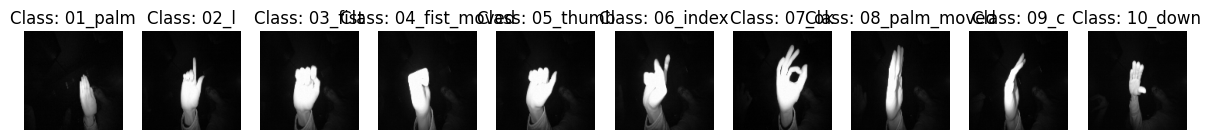

In [26]:
import matplotlib.pyplot as plt

# Display sample images from each class
classes = np.unique(y)
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    idx = y.tolist().index(cls)
    axes[i].imshow(all_images[idx], cmap='gray')
    axes[i].set_title(f"Class: {le.inverse_transform([cls])[0]}")
    axes[i].axis('off')
plt.show()


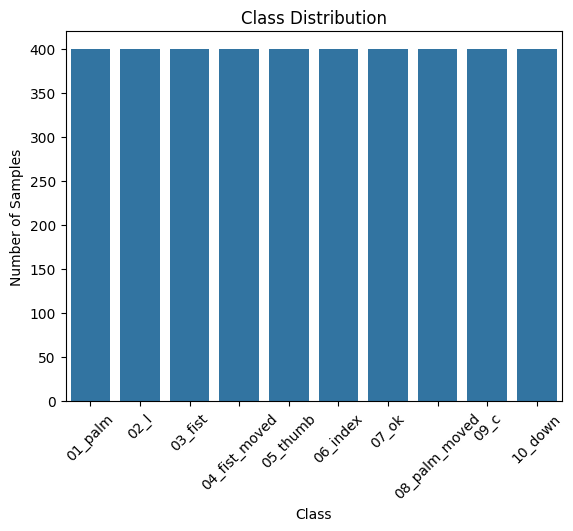

In [27]:
import seaborn as sns

# Plot the distribution of classes, we can see that the classes are balanced
sns.countplot(x=y)
plt.xlabel('Class')
plt.xticks(ticks=classes, labels=le.inverse_transform(classes), rotation=45)
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()


In [28]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Prepare data
# X here is a 4D array (number of samples, height, width, channels)
# which we can directly use in a Conv2D layer in the next code block
X = np.array(all_images).reshape(-1, desired_size[0], desired_size[1], 1)  # Add channel dimension

# Convert labels to one-hot encoded vectors
y_categorical = to_categorical(y)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Build the CNN model
# The type of CNN we will use is a Sequential model which is
# a linear stack of layers. We will add convolutional, pooling,
# and dense layers to this model.
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(desired_size[0], desired_size[1], 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Fit the model with validation
# history here is a history object that contains the loss and accuracy values during training
# which we can use to plot the training and validation loss and accuracy

#TODO: Tune these hyper parameters
#Hyper parameters
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# See below how the loss improves and the accuracy increases (by a lot) over time
# This means that the training is working and the model is learning from the data


In [30]:
# Tune these hyper parameters

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras_tuner import Hyperband  

def build_model(hp):
    model = Sequential()
    
    # First Convolutional Layer with tunable number of filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(desired_size[0], desired_size[1], 1)
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Convolutional Layer with tunable number of filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten and Dense Layers with tunable dense units and dropout rate
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output Layer
    model.add(Dense(len(classes), activation='softmax'))
    
    # Compile model with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [31]:
from keras_tuner import Hyperband

# Define the tuner and its parameters
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuning_dir',
    project_name='hand_sign_tuning'
)

Reloading Tuner from tuning_dir\hand_sign_tuning\tuner0.json


In [ ]:
# Run the tuner search.
# Only necessary if you want to run the search again

#tuner.search(X_train, y_train, epochs=20, validation_split=0.1, batch_size=32)

In [32]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\bao-n\Documents\Skole\DAT540\dat-540-project\venv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [37]:
# Display the best hyperparameters
# best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
# print("Best Hyperparameters:")
# print(f"Conv Layer 1 Filters: {best_hyperparameters.get('conv_1_filters')}")
# print(f"Conv Layer 1 Kernel Size: {best_hyperparameters.get('conv_1_kernel')}")
# print(f"Conv Layer 2 Filters: {best_hyperparameters.get('conv_2_filters')}")
# print(f"Conv Layer 2 Kernel Size: {best_hyperparameters.get('conv_2_kernel')}")
# print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
# print(f"Dropout Rate: {best_hyperparameters.get('dropout')}")
# print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

Best Hyperparameters:
Conv Layer 1 Filters: 32
Conv Layer 1 Kernel Size: 5
Conv Layer 2 Filters: 256
Conv Layer 2 Kernel Size: 3
Dense Units: 128
Dropout Rate: 0.30000000000000004
Learning Rate: 1e-05


In [ ]:
# # Evaluate the model on the test set
# test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 1.1274e-04
Test Accuracy: 1.0000


In [ ]:
from tensorflow.keras.layers import Dropout
# X is your image data, shape: (num_samples, height, width, channels)
# y is your labels, shape: (num_samples,)

# Ensure y is in integer format (not one-hot encoded)
# If y is one-hot encoded, convert it back to integer labels
if y.ndim > 1:
    y_labels = np.argmax(y, axis=1)
else:
    y_labels = y
    
def build_model_with_parameters():

    # Best Hyperparameters:
    # Conv Layer 1 Filters: 128
    # Conv Layer 1 Kernel Size: 3
    # Conv Layer 2 Filters: 96
    # Conv Layer 2 Kernel Size: 5
    # Dense Units: 192
    # Dropout Rate: 0.30000000000000004
    # Learning Rate: 1e-05

    # Best Hyperparameters
    conv_1_filters = 128
    conv_1_kernel = 3
    conv_2_filters = 96
    conv_2_kernel = 5
    dense_units = 192
    dropout_rate = 0.3
    learning_rate = 0.00001

    

    # Build the model
    model = Sequential()
    model.add(Conv2D(filters=conv_1_filters,
                     kernel_size=(conv_1_kernel, conv_1_kernel),
                     activation='relu',
                     input_shape=(desired_size[0], desired_size[1], 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=conv_2_filters,
                     kernel_size=(conv_2_kernel, conv_2_kernel),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(classes), activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

from sklearn.model_selection import StratifiedKFold

# Define the number of folds
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

for train_index, val_index in skf.split(X, y_labels):
    print(f'Fold {fold_no} -------------------------------------')

    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Ensure labels are one-hot encoded
    y_train_categorical = to_categorical(y_train, num_classes=len(classes))
    y_val_categorical = to_categorical(y_val, num_classes=len(classes))

    # Build a fresh model for each fold
    model = build_model_with_parameters()

    # Train the model
    history = model.fit(X_train, y_train_categorical,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_val, y_val_categorical),
                        verbose=1)

    # Evaluate the model
    scores = model.evaluate(X_val, y_val_categorical, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} = {scores[0]:.4f}; {model.metrics_names[1]} = {scores[1]:.4f}')
    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1


print('-------------------------------------')
print('Score per fold')
for i in range(len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - Accuracy: {accuracy_per_fold[i]:.4f}%')
print('-------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold):.4f} (+- {np.std(accuracy_per_fold):.4f})')
print(f'> Loss: {np.mean(loss_per_fold):.4f}')
print('-------------------------------------')


# Score per fold
# > Fold 1 - Loss: 0.0039 - Accuracy: 1.0000%
# > Fold 2 - Loss: 0.0066 - Accuracy: 1.0000%
# > Fold 3 - Loss: 0.0054 - Accuracy: 1.0000%
# > Fold 4 - Loss: 0.0044 - Accuracy: 1.0000%
# > Fold 5 - Loss: 0.0051 - Accuracy: 1.0000%
# -------------------------------------
# Average scores for all folds:
# > Accuracy: 1.0000 (+- 0.0000)
# > Loss: 0.0051


In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Convert one-hot encoded y_test back to labels
y_test_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step
Test Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

      01_palm       0.81      0.76      0.78        82
         02_l       0.87      0.74      0.80        98
      03_fist       0.71      0.73      0.72        84
04_fist_moved       0.64      0.73      0.69        67
     05_thumb       0.62      0.78      0.69        72
     06_index       0.64      0.76      0.70        80
        07_ok       0.75      0.70      0.72        77
08_palm_moved       0.94      0.81      0.87        93
         09_c       0.85      0.76      0.80        74
      10_down       0.86      0.88      0.87        73

     accuracy                           0.76       800
    macro avg       0.77      0.76      0.76       800
 weighted avg       0.78      0.76      0.77       800



In [ ]:
import seaborn as sns

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Shows actual (y-axis) vs predicted values (x-axis)
#The diagonal represents the correct predictions
#The diagonal shows that the model never predicts false positives



In [35]:
#Save the model
best_model.save('gesture_recognition_model.keras')

In [ ]:
#TODO: Cross validation
# Cross validation is a technique used to evaluate the performance of a model
# on a limited data sample. It is used to estimate how the model will perform
# in a general setting. The idea is to split the data into multiple folds
# and train the model on all but one fold and test on the remaining fold.

# This can be implemented using the KFold class from scikit-learn.

In [ ]:
#TODO: Data augmentation
# Data augmentation is a technique to artificially create new training data from existing training data.
# This is done by applying random (but realistic) transformations to the existing data.
# For example, you can rotate, flip, zoom in, or change the brightness of an image.
# This can help the model generalize better to new, unseen data.
# Keras provides a built-in ImageDataGenerator class that can be used for data augmentation.

from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [1]:
import os
import cv2
# If our use case is to be able to recognize gestures in real-time, then a step we need to take is to  
# access the webcam and use the model to make predictions on the video stream.

# TODO: Acess the webcam
# To access the webcam, we can use the OpenCV library which provides
# a VideoCapture class to capture video from the webcam.

# Ensure the 'data' folder exists; if not, create it
os.makedirs('data/webcam', exist_ok=True)

cap = cv2.VideoCapture(0)

img_counter = 0

desired_size = (128, 128)

if not cap.isOpened():
    print("Cannot open camera")
    exit()
#video capture
#fourcc = cv.VideoWriter_fourcc(*'DIVX')
#out = cv.VideoWriter('output.avi', fourcc, 20.0, (128,  128))

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
 
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # write the frame video
    #out.write(gray)

    # Display the resulting frame
    cv2.imshow('frame', gray)

    if cv2.waitKey(1) == ord(' '): #space bar to capture frame
        img_name = f"data/webcam/image_{img_counter}.png"
        cv2.imwrite(img_name, gray) 

        img_counter += 1

    if cv2.waitKey(1) == ord('q'): #q to end program
        break
 
# When everything done, release the capture
cap.release()
#out.release()
cv2.destroyAllWindows()

#Access the webcam and press space bar to capture a frame as image and q to end program. little lag between keypress
#images is nomalized before saving so it can be used for prediction but cant be view directly for users

In [ ]:
#TODO: Make predictions on the video stream from the webcam
# This is something we can use in our presentation of the project
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model


model = load_model('gesture_recognition_model.keras')

image_folder = 'data/webcam/'

image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Define the input size expected by the model
input_size = (128, 128) 

# List of class labels (replace with your actual class labels)
class_labels = ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']

# Initialize variables to store predictions
correct_predictions = 0
total_predictions = 0

# webcam image to correct class_label index
true_labels = {
    'image_0.png': 0,
    'image_1.png': 1,
    'image_2.png': 2,
    'image_3.png': 3,
    'image_4.png': 4,
    'image_5.png': 5,
    'image_6.png': 6,
    'image_7.png': 7,
    'image_8.png': 8,
    'image_9.png': 9,
}

# Iterate over the saved images
for image_file in image_files:
    img = cv2.imread(os.path.join(image_folder, image_file), cv2.IMREAD_GRAYSCALE)
    
    img_resized = cv2.resize(img, input_size)
    img_normalized = img_resized.astype('float32') / 255.0
    
    # Add batch dimension (model expects input shape: (batch_size, height, width, channels))
    img_batch = np.expand_dims(img_normalized, axis=0)  # Shape: (1, 128, 128)
    img_batch = np.expand_dims(img_batch, axis=-1)      # Shape: (1, 128, 128, 1)
    
    # Use the model to make a prediction
    predictions = model.predict(img_batch)
    #print(f"Raw predictions for {image_file}: {predictions}")
    
    # Get the class index with the highest probability
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_labels[predicted_class]
    
    # Print the prediction
    print(f"Image: {image_file}, Predicted Gesture: {predicted_label}")
    
    # Optional: Evaluate accuracy if true labels are available
    if image_file in true_labels:
        total_predictions += 1
        if predicted_class == true_labels[image_file]:
            correct_predictions += 1

# Print evaluation results if true labels are provided
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Model Accuracy on Test Images: {accuracy:.2f}%")
else:
    print("No true labels provided; evaluation skipped.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Raw predictions for image_0.png: [[0.10612291 0.09656397 0.10105545 0.10218869 0.09534904 0.1046883
  0.09824131 0.10899191 0.09473611 0.09206239]]
Image: image_0.png, Predicted Gesture: 08_palm_moved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Raw predictions for image_1.png: [[0.10439553 0.0947285  0.10102193 0.10292026 0.0964168  0.10553958
  0.0966927  0.11053123 0.09594584 0.09180766]]
Image: image_1.png, Predicted Gesture: 08_palm_moved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Raw predictions for image_2.png: [[0.10373645 0.09530778 0.10356796 0.1046912  0.09458958 0.10676154
  0.09560795 0.11298846 0.09465028 0.08809876]]
Image: image_2.png, Predicted Gesture: 08_palm_moved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Raw predictions for image_3.png: [[0.10033352 0.09566372 0.10266329 0.10478087 0.09510731 0.10751289
  0.09666781 0.11227503 0.09598248 0.08901314]]
Image: image_3.png, Predicted Gesture: 08_palm_moved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
R